In [42]:
import pandas as pd
import altair as alt
import plotly.express as px
import numpy as np
import datetime
import matplotlib.pyplot as plt
!pip install squarify
import squarify

In [5]:
df_ecommerce_retail = pd.read_excel('ecommerce retail.xlsx')
df_ecommerce_retail.dropna(subset = ['CustomerID'], inplace=True)
df_ecommerce_retail['CustomerID'] = df_ecommerce_retail['CustomerID'].astype(int)
df_ecommerce_retail = df_ecommerce_retail[df_ecommerce_retail['Quantity'] > 0]
df_ecommerce_retail = df_ecommerce_retail[df_ecommerce_retail['UnitPrice'] > 0]
df_ecommerce_retail.to_csv('ecommerce_retail_cleaned.csv', index=False)

In [21]:
delivered = df_ecommerce_retail[df_ecommerce_retail['Quantity'] >= 0]
delivered['InvoiceNo'] = delivered['InvoiceNo'].astype(int)
delivered['Revenue'] = delivered['Quantity'] * delivered['UnitPrice']
delivered
agg_delivered = delivered.groupby(['InvoiceNo', 'Country', 'CustomerID']).agg({'InvoiceDate': 'max',
                                                                              'Revenue': 'sum'}).reset_index()
agg_delivered
x = agg_delivered[['InvoiceNo', 'InvoiceDate', 'CustomerID', 'Revenue']]
rfm = x.groupby('CustomerID').agg({'InvoiceDate': 'max', 'InvoiceNo': 'count', 'Revenue': 'sum'}).reset_index()
rfm.columns = ['CustomerID', 'Max_date', 'Frequency', 'Monetary']
today = datetime.datetime.strptime('2011-12-31', '%Y-%m-%d')
rfm['Recency'] = (today - rfm['Max_date']).dt.days
rfm = rfm.drop('Max_date', axis=1)
rfm
df_ecommerce_retail_cleaned = pd.read_csv('ecommerce_retail_cleaned.csv')
df_ecommerce_retail_cleaned['InvoiceDate'] = pd.to_datetime(df_ecommerce_retail_cleaned['InvoiceDate'])
r_labels, f_labels, m_labels = range(5, 0, -1), range(1, 6), range(1, 6)

rfm['R_score'] = pd.qcut(rfm['Recency'], q=5, labels=r_labels)
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=5, labels=f_labels)
rfm['M_score'] = pd.qcut(rfm['Monetary'], q=5, labels=m_labels)

rfm


,CustomerID,Frequency,Monetary,Recency,R_score,F_score,M_score
0,12346,1,77183.60,346,1,1,5
1,12347,7,4310.00,23,5,5,5
2,12348,4,1797.24,96,2,4,4
3,12349,1,1757.55,39,4,1,4
4,12350,1,334.40,331,1,1,2
...,...,...,...,...,...,...,...
4333,18280,1,180.60,298,1,2,1
4334,18281,1,80.82,201,1,2,1
4335,18282,2,178.05,28,5,3,1
4336,18283,16,2094.88,24,5,5,5


In [24]:
import altair as alt
chart_recency = alt.Chart(rfm).mark_bar().encode(
    x=alt.X('Recency:Q', bin=True, title='Recency'),
    y=alt.Y('count()', title='Số lượng khách hàng'),
    tooltip=[alt.Tooltip('Recency:Q', bin=True), 'count()']
).properties(
    title='Phân bố Recency'
).interactive()
chart_frequency = alt.Chart(rfm).mark_bar().encode(
    x=alt.X('Frequency:Q', bin=True, title='Frequency'),
    y=alt.Y('count()', title='Số lượng khách hàng'),
    tooltip=[alt.Tooltip('Frequency:Q', bin=True), 'count()']
).properties(
    title='Phân bố Frequency'
).interactive()
chart_monetary = alt.Chart(rfm).mark_bar().encode(
    x=alt.X('MonetaryValue:Q', bin=True, title='MonetaryValue'),
    y=alt.Y('count()', title='Số lượng khách hàng'),
    tooltip=[alt.Tooltip('MonetaryValue:Q', bin=True), 'count()']
).properties(
    title='Phân bố MonetaryValue'
).interactive()
chart = alt.vconcat(chart_recency, chart_frequency, chart_monetary)
chart.display()


alt.VConcatChart(...)

In [37]:
rfm['RFM_Score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)
rfm['RFM_Score'] = rfm['RFM_Score'].astype(int)
seg = pd.read_excel('ecommerce retail.xlsx', sheet_name='Segmentation')
seg.columns = [col.replace(' ', '_') for col in seg.columns]
seg['RFM_Score'] = seg['RFM_Score'].str.split(',') # convert comma-separated string to a list of rfm scores
seg = seg.explode('RFM_Score').reset_index(drop=True) # transform each element of a list-like to a row
seg['RFM_Score'] = seg['RFM_Score'].astype(int)
seg.sort_values(by='RFM_Score')
joined = rfm.merge(seg, how='left', on='RFM_Score')
grp = joined.groupby('Segment').agg({'CustomerID': 'count',
                                     'Monetary': 'sum',
                                     'Recency': 'mean'}).reset_index()
grp.columns = ['Segment', 'Cust_count', 'Total_monetary', 'Avg_recency']
grp.sort_values(by='Cust_count', ascending=False, inplace=True)
grp['Count_share'] = grp['Cust_count'] / grp['Cust_count'].sum()
grp['Monetary_share'] = grp['Total_monetary'] / grp['Total_monetary'].sum()
grp



,Segment,Cust_count,Total_monetary,Avg_recency,Count_share,Monetary_share
3,Champions,835,5604376.680,31.816766,0.192485,0.628899
4,Hibernating customers,696,285673.342,169.916667,0.160443,0.032057
5,Lost customers,486,97405.610,296.557613,0.112033,0.010930
6,Loyal,428,1021224.390,57.070093,0.098663,0.114597
1,At Risk,422,751808.221,164.419431,0.097280,0.084365
9,Potential Loyalist,414,225740.110,47.053140,0.095436,0.025332
0,About To Sleep,283,77885.540,107.325088,0.065237,0.008740
7,Need Attention,280,462835.741,54.350000,0.064546,0.051937
8,New Customers,267,59755.620,48.891386,0.061549,0.006706
10,Promising,136,121031.350,45.904412,0.031351,0.013582


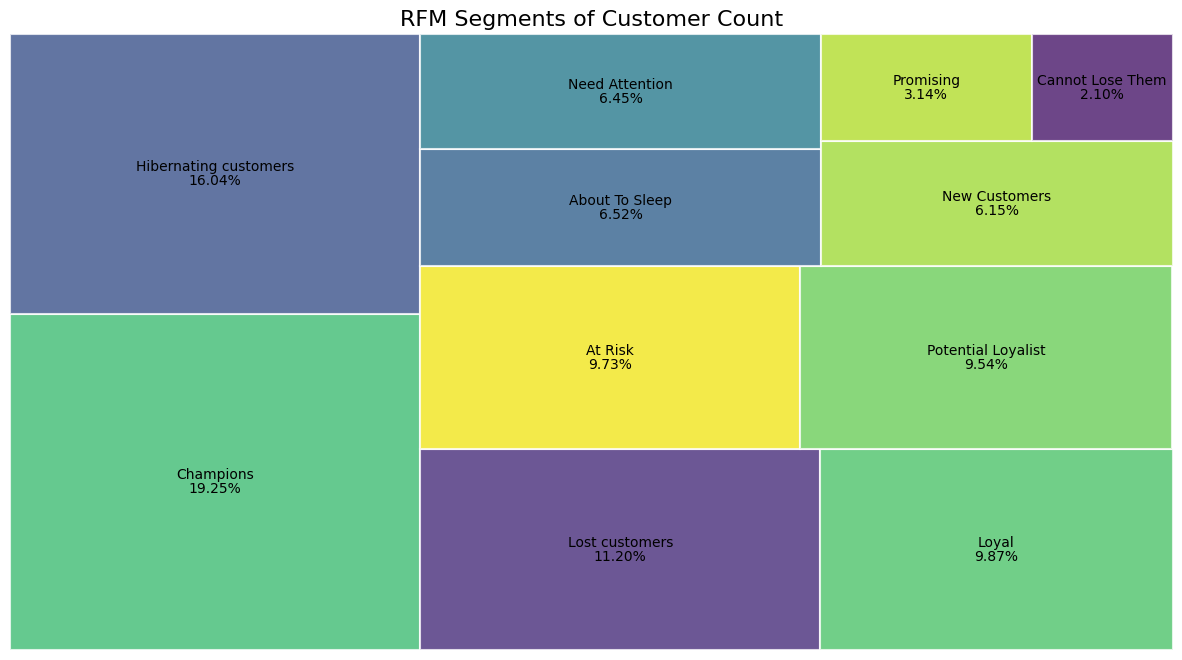

In [44]:
fig, ax = plt.subplots(1, figsize = (15,8))

squarify.plot(sizes=grp['Cust_count'],
              label=grp['Segment'],
              value=[f'{x*100:.2f}%' for x in grp['Count_share']],
              alpha=.8,
              bar_kwargs=dict(linewidth=1.5, edgecolor="white")
             )
plt.title('RFM Segments of Customer Count', fontsize=16)
plt.axis('off')
plt.show()

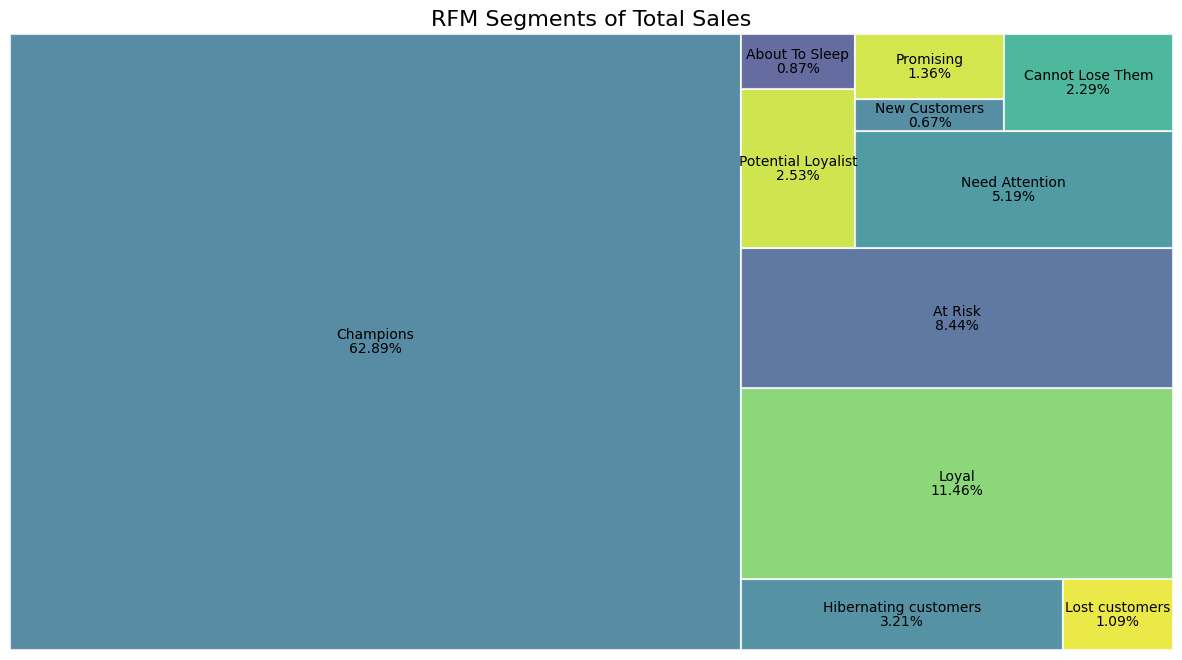

In [46]:
fig, ax = plt.subplots(1, figsize = (15,8))

squarify.plot(sizes=grp['Monetary_share'],
              label=grp['Segment'],
              value=[f'{x*100:.2f}%' for x in grp['Monetary_share']],
              alpha=.8,
              bar_kwargs=dict(linewidth=1.5, edgecolor="white")
             )
plt.title('RFM Segments of Total Sales', fontsize=16)
plt.axis('off')
plt.show()

In [ ]:
#Hiện trạng công ty:
- Dựa trên các biểu đồ phân bố Frequency, Recency, Monetary
Ở biểu đồ phân bố số lượng khách hàng theo Recency, có thể thấy có đến 1571 khách có recency từ 0-50
và biểu giảm dần từ trái qua phải, thể hiện rằng phần lớn khách hàng có thời gian mua gần đây
Ở biểu đồ phân bố số lượng khách hàng theo Monetary, có thể thấy số tiền khách chi cho đơn hàng còn thấp,
với số lượng khách chi dưới 50000 là 4318, chiếm tỉ trọng cao trong tổng số khách hàng
Ở biểu đồ phân bố số lượng khách hàng theo Recency, đa số khách mua hàng với tần suất thấp
- Dựa trên biểu đồ phân bố phân khúc khách hàng
Potential Loyalist là nhóm khách hàng đông nhất và có tiềm năng có thể trở thành Loyal Customers.
Họ đã mua hàng gần đây và có tần suất mua hàng khá, nhưng số tiền chi ra chưa được cao
Tiếp đến là 2 tệp khách có tỉ trọng cao t2 và t3 là At Risk và Need Attention, cả 2 tệp khách này phản ánh
1 lượng lớn khách hàng cũ có khả năng ngừng mua hàng bên cty
Chiếm tỉ trọng thấp nhất là 3 tệp khách: Lost Customers, New Customer và Champions
-> Qua những chỉ số các biểu đồ thể hiện có thể thấy, cty vẫn có 1 lượng lớn khách hàng tiềm năng để
trở thành khách hàng trung thành, tuy nhiên tỉ lệ khách có nguy cơ không mua hàng nữa cũng khá cao,
cty ít thu hút được các khách hàng mới và các khách hàng trung thành, chi tiêu nhiều cũng còn thấp và thụ động
-> Cty nên chuyển đổi tệp khách hàng tiềm năng thành khách hàng trung thành bằng các phương pháp như
 Tìm hiểu sở thích và hành vi mua sắm của khách hàng tiềm năng để đưa ra các đề xuất phù hợp, thiết kế các chương trình
khách hàng thân thiết. Đối với tệp khách có nguy cơ không mua hàng nữa thì nên có phương hướng liên lạc
khảo sát về trải nghiệm mua hàng của khách tại cty. Để kích cầu tệp khách loyal và champions, cty nên có
chương trình chăm sóc riêng cho khách VIP, đảm bảo rằng họ sẽ có những ưu đãi tốt nhất cũng như là được giải quyết
vấn đề sớm nhất. Thu hút các khách mới bằng cách đưa ra các chiến dịch tiếp thị phù hợp với xu hướng thị trường, cũng
như những ưu đãi mua hàng lần đầu cho khách
